In [5]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from pycaret.classification import *

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [6]:
df_trans = pd.read_csv('dh_transactions.csv')
df_trans.head(3)

,upc,dollar_sales,units,time_of_transaction,geography,week,household,store,basket,day,coupon
0,7680850106,0.80,1,1100,2,1,125434,244,1,1,0
1,3620000470,3.59,1,1100,2,1,125434,244,1,1,0
2,1800028064,2.25,1,1137,2,1,108320,244,2,1,0


In [7]:
# remove outliner
def filter_outliner(df, column_name):
    q_low = df[column_name].quantile(0.0003) # mean-3sd
    q_hi  = df[column_name].quantile(0.9997) # mean+3sd
    df_filtered = df[(df[column_name] <= q_hi) & (df[column_name] >= q_low)]
    return df_filtered

# before removed 5,197,681 row
# after removed 5,184,441 row

df_trans = filter_outliner(df_trans, 'units')
# df_trans = df_trans.loc[(df_trans['day']<=365) & (df_trans['dollar_sales']>0)]
df_trans = df_trans.loc[df_trans['dollar_sales']>0]
df_trans = df_trans.drop_duplicates()
df_trans.head(3)

,upc,dollar_sales,units,time_of_transaction,geography,week,household,store,basket,day,coupon
0,7680850106,0.80,1,1100,2,1,125434,244,1,1,0
1,3620000470,3.59,1,1100,2,1,125434,244,1,1,0
2,1800028064,2.25,1,1137,2,1,108320,244,2,1,0


In [8]:
df_trans_y1 = df_trans.loc[df_trans['week']<=52]
df_trans_y1.head(3)

,upc,dollar_sales,units,time_of_transaction,geography,week,household,store,basket,day,coupon
0,7680850106,0.80,1,1100,2,1,125434,244,1,1,0
1,3620000470,3.59,1,1100,2,1,125434,244,1,1,0
2,1800028064,2.25,1,1137,2,1,108320,244,2,1,0


In [9]:
df_sumbkt = df_trans_y1.groupby(['household'])[['dollar_sales']].apply('sum').reset_index()
df_sumbkt.columns = ['household', 'total_spending']
print(df_sumbkt.head())

df_countbkt = df_trans_y1.groupby('household')[['basket']].nunique().reset_index()
df_countbkt.columns = ['household', 'bkt_count']
print(df_countbkt.head())

   household  total_spending
0          1           10.48
1          2          130.44
2          3            5.28
3          5            9.83
4          6            0.79
   household  bkt_count
0          1          5
1          2         37
2          3          1
3          5          3
4          6          1


In [10]:
df_fm = df_countbkt.merge(df_sumbkt, on='household')
df_fm.head(3)

,household,bkt_count,total_spending
0,1,5,10.48
1,2,37,130.44
2,3,1,5.28


In [11]:
X = df_fm[['bkt_count', 'total_spending']]
X.head(3)

,bkt_count,total_spending
0,5,10.48
1,37,130.44
2,1,5.28


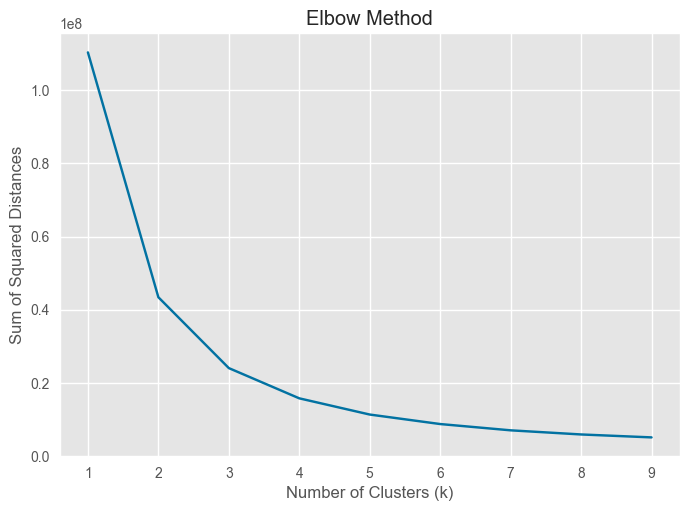

In [12]:
k_values = range(1, 10)

# Perform k-means clustering for each k and calculate the sum of squared distances
sse = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)  # Sum of squared distances to the closest cluster center

# Plot the elbow curve
plt.plot(k_values, sse, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method')
plt.show()

In [13]:
scaler = MinMaxScaler()

for col in list(X.columns):
    X[col] = scaler.fit_transform(X[[col]])

# X['bkt_count'] = scaler.fit_transform(X[['bkt_count']])
# X['dollar_sales'] = scaler.fit_transform(X[['dollar_sales']])

In [14]:
X.head(3)

,bkt_count,total_spending
0,0.035398,0.018590
1,0.318584,0.231579
2,0.000000,0.009357


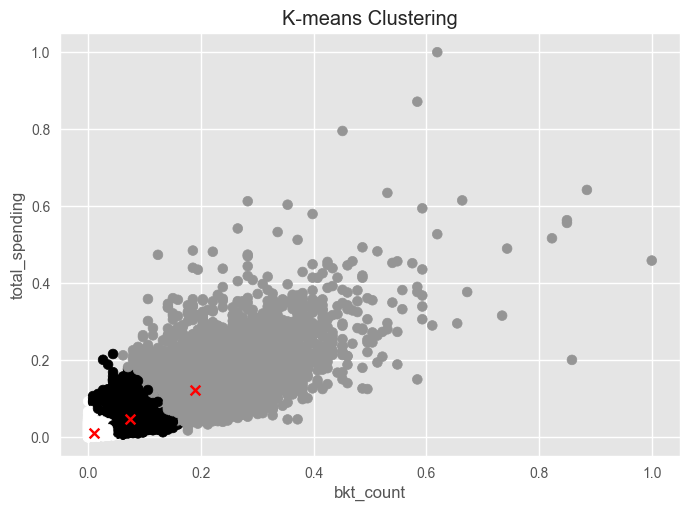

In [15]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(X)

labels = kmeans.labels_
centers = kmeans.cluster_centers_

plt.scatter(X['bkt_count'], X['total_spending'], c=labels)
# Plot cluster centers as markers
plt.scatter(centers[:, 0], centers[:, 1], marker='x', color='red')
plt.xlabel('bkt_count')
plt.ylabel('total_spending')
plt.title('K-means Clustering')
plt.show()

In [16]:
df_fm['segments'] = labels
df_fm.head(3)

,household,bkt_count,total_spending,segments
0,1,5,10.48,0
1,2,37,130.44,1
2,3,1,5.28,0


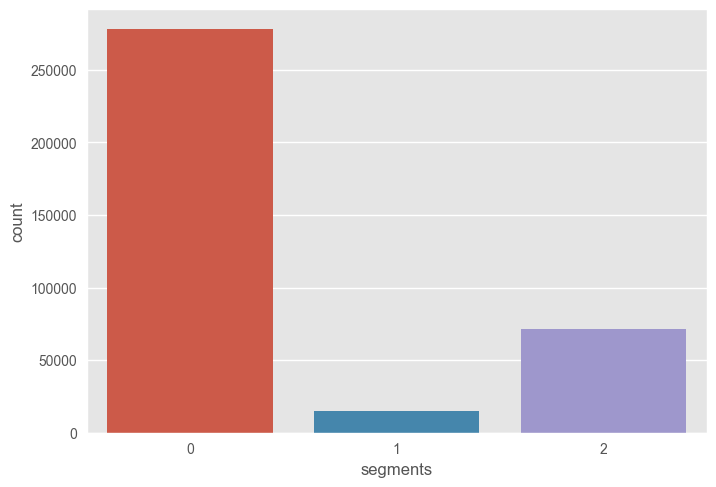

In [18]:
sns.countplot(x='segments', data=df_fm)
plt.show()

In [20]:
df_nday = df_trans.groupby('household')[['day']].nunique().reset_index()
df_nday['365/nday'] = 365/df_nday['day']
df_nday.head(3)

,household,day,365/nday
0,1,11,33.181818
1,2,85,4.294118
2,3,1,365.000000


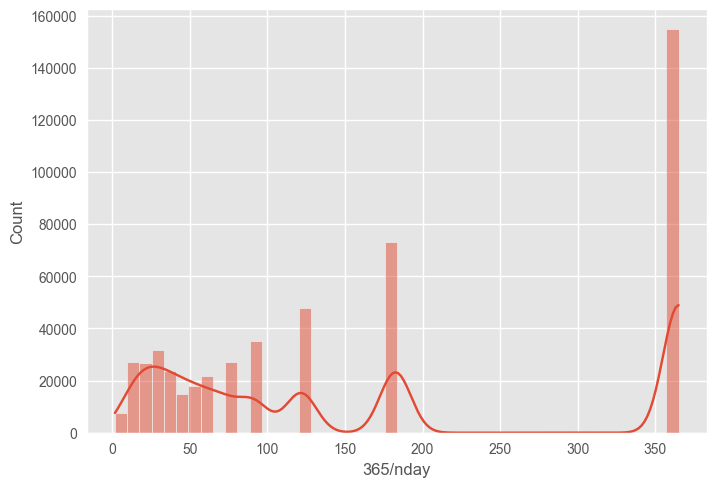

In [21]:
sns.histplot(data=df_nday, x='365/nday', kde=True)
plt.show()